# CNN definition and training

The following notebook is runned on google colab, therefore it can not be runned as is, as files are missing. 

Nonetheless, results obtained are reproducible by first extracting the required features and by loading them instead of the Google Drive content.

## Setting up the environment

The first step is to import the required libraries and fix random seeds.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

### Fixing random seeds

In [3]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)
from keras import backend as K
session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
tensorflow.compat.v1.keras.backend.set_session(sess)

## Load and display features
The features are extracted locally and loaded into Google Colab. 
They are savved in a numpy array on disk.

In [4]:
features = np.load("/content/gdrive/MyDrive/cnn/stft_features.npy")
labels = np.load("/content/gdrive/MyDrive/cnn/stft_labels.npy")

## Plotting the classes
Here we can see an example of image obtained for each class. 

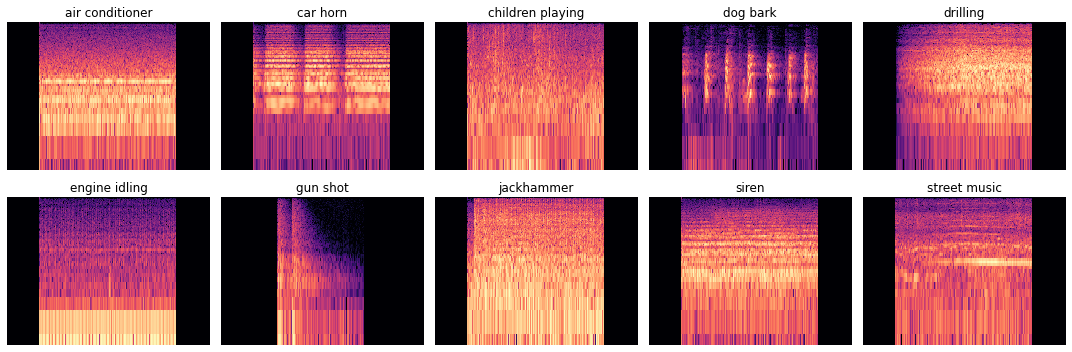

In [5]:
dd = {"air conditioner": 369,
      "car horn": 4420,
      "children playing": 102,
      "dog bark": 0,
      "drilling": 59,
      "engine idling": 19,
      "gun shot": 14,
      "jackhammer": 37,
      "siren": 21,
      "street music": 169}

fig, ax = plt.subplots(2, 5, figsize=(15, 5))


for i,(k,v) in enumerate(dd.items()):
    ax[i//5][i%5].axis("off")
    img1 = librosa.display.specshow(librosa.amplitude_to_db(features[v], ref=np.max),
                                    y_axis='log', 
                                    x_axis='time', 
                                    ax=ax[i//5][i%5])
    ax[i//5][i%5].set_title(k)
fig.tight_layout()
#plt.savefig('class_images.png', dpi=300)

## Scaling pixel values
The scaler is a standard scaler, and it will be used on the test set later on.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x, y, z = features.shape
scaled_features = features.reshape(-1, z)
scaled_features = scaler.fit_transform(scaled_features)
scaled_features = scaled_features.reshape(x, y, z)
X_train = scaled_features.reshape(x, y, z, 1)

# Model definition

The first step is to define a cnn model and test it with cross validation on the training set. As the same stratified cross valiation is used, the results are comparable to the Multilayer perceptron.

In [6]:
def get_cnn(conv=16, neurons=[120, 50], learning_rate=0.001, conv_strides=1, pooling_strides=3):
    input_shape=(128,256)

    layer_list = [layers.Conv2D(conv, kernel_size=(5, 5), strides = (conv_strides, conv_strides), activation='relu',padding='same'),
                  layers.Conv2D(conv, kernel_size=(3, 3), activation='relu'),
                  layers.MaxPooling2D(pool_size=(2, 2),strides=pooling_strides),
                  layers.Conv2D(conv*2, kernel_size=(3, 3), strides = (conv_strides, conv_strides), activation='relu'),
                  layers.Conv2D(conv*2, kernel_size=(3, 3), activation='relu'),
                  layers.MaxPooling2D(pool_size=(2, 2),strides=3),
                  layers.Flatten()]

    for n in neurons:
      layer_list.append(layers.Dense(n, activation='relu'))
    layer_list.append(layers.Dense(10, activation='softmax'))
    
    model = models.Sequential(layer_list)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

## Testing different models

We now test four different architectures to see their performances with cross validation, we basically test if it is better to put strides on convolutional or pooling layers, then, we test an higher number of convolutional filters with the same logic.

### 8 filters

In [7]:
net = get_cnn(conv=8, neurons=[2000, 800, 200, 60], conv_strides=1, pooling_strides=3)
net.fit(X_train[[1,2]], labels[[1,2]], verbose=0)
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 256, 8)       208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 254, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 85, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 83, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 81, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 27, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5616)              0

In [8]:
net = get_cnn(conv=8, neurons=[300, 150, 80, 25], conv_strides=2, pooling_strides=2)
net.fit(X_train[[1,2]], labels[[1,2]], verbose=0)
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 128, 8)        208       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 126, 8)        584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 63, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 31, 16)        1168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 29, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 10, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)              

### 16 filters

In [9]:
net = get_cnn(conv=16, neurons=[5000, 2000, 800, 200, 60], conv_strides=1, pooling_strides=3)
net.fit(X_train[[1,2]], labels[[1,2]], verbose=0)
net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 256, 16)      416       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 254, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 85, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 83, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 38, 81, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11232)            

In [10]:
net = get_cnn(conv=16, neurons=[600, 200, 80, 25], conv_strides=2, pooling_strides=2)
net.fit(X_train[[1,2]], labels[[1,2]], verbose=0)
net.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 128, 16)       416       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 126, 16)       2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 63, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 31, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 10, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)             

In [8]:
def get_cross_scores(conv=16, neurons=[100, 40], conv_strides=2, pooling_strides=3, epochs=10, learning_rate=0.001):

  kf = StratifiedKFold(n_splits=5)
  class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels)
  weights_dict = dict(zip(np.unique(labels), class_weights))
  stopper = EarlyStopping(monitor='accuracy', patience=2, verbose=1)

  res = []
  for train_index, test_index in kf.split(X_train, labels):
    m = get_cnn(conv=conv, neurons=neurons, conv_strides=conv_strides, pooling_strides=pooling_strides, learning_rate=learning_rate)
    m.fit(X_train[train_index],
          labels[train_index],
          epochs=epochs,
          verbose=1,
          class_weight=weights_dict, 
          callbacks=[stopper], 
          batch_size=32)
    
    scores = m.evaluate(X_train[test_index], 
              labels[test_index])
    
    res.append(scores)
  return np.mean([e[1] for e in res]), np.std([e[1] for e in res])

## Cross validation run

In [9]:
res1 = get_cross_scores(conv=8, neurons=[2000, 800, 200, 60], conv_strides=1, pooling_strides=3, epochs=15)
print(f"Mean accuracy: {res1[0]} Std: {res1[1]}")

Epoch 1/15
113/113 [==============================] - 8s 51ms/step - loss: 1.7973 - accuracy: 0.3579
Epoch 2/15
113/113 [==============================] - 5s 48ms/step - loss: 1.1533 - accuracy: 0.5863
Epoch 3/15
113/113 [==============================] - 5s 48ms/step - loss: 0.7193 - accuracy: 0.7452
Epoch 4/15
113/113 [==============================] - 5s 48ms/step - loss: 0.4436 - accuracy: 0.8413
Epoch 5/15
113/113 [==============================] - 5s 48ms/step - loss: 0.3610 - accuracy: 0.8741
Epoch 6/15
113/113 [==============================] - 6s 49ms/step - loss: 0.2488 - accuracy: 0.9116
Epoch 7/15
113/113 [==============================] - 6s 49ms/step - loss: 0.1570 - accuracy: 0.9455
Epoch 8/15
113/113 [==============================] - 5s 49ms/step - loss: 0.1075 - accuracy: 0.9647
Epoch 9/15
113/113 [==============================] - 5s 48ms/step - loss: 0.1739 - accuracy: 0.9464
Epoch 10/15
113/113 [==============================] - 5s 48ms/step - loss: 0.0886 - accura

In [10]:
res2 = get_cross_scores(conv=8, neurons=[300, 150, 80, 25], conv_strides=2, pooling_strides=2, epochs=15)
print(f"Mean accuracy: {res2[0]} Std: {res2[1]}")

Epoch 1/15
113/113 [==============================] - 3s 16ms/step - loss: 1.9661 - accuracy: 0.2809
Epoch 2/15
113/113 [==============================] - 2s 15ms/step - loss: 1.3586 - accuracy: 0.5274
Epoch 3/15
113/113 [==============================] - 2s 15ms/step - loss: 1.0190 - accuracy: 0.6288
Epoch 4/15
113/113 [==============================] - 2s 15ms/step - loss: 0.8017 - accuracy: 0.7038
Epoch 5/15
113/113 [==============================] - 2s 15ms/step - loss: 0.7007 - accuracy: 0.7422
Epoch 6/15
113/113 [==============================] - 2s 15ms/step - loss: 0.5776 - accuracy: 0.7936
Epoch 7/15
113/113 [==============================] - 2s 15ms/step - loss: 0.4639 - accuracy: 0.8311
Epoch 8/15
113/113 [==============================] - 2s 14ms/step - loss: 0.4179 - accuracy: 0.8516
Epoch 9/15
113/113 [==============================] - 2s 15ms/step - loss: 0.3795 - accuracy: 0.8547
Epoch 10/15
113/113 [==============================] - 2s 15ms/step - loss: 0.3043 - accura

In [11]:
res3 = get_cross_scores(conv=16, neurons=[5000, 2000, 800, 200, 60], conv_strides=1, pooling_strides=3, epochs=15)
print(f"Mean accuracy: {res3[0]} Std: {res3[1]}")

Epoch 1/15
113/113 [==============================] - 13s 97ms/step - loss: 1.8772 - accuracy: 0.3001
Epoch 2/15
113/113 [==============================] - 10s 93ms/step - loss: 1.2500 - accuracy: 0.5488
Epoch 3/15
113/113 [==============================] - 11s 93ms/step - loss: 0.7962 - accuracy: 0.7158
Epoch 4/15
113/113 [==============================] - 10s 93ms/step - loss: 0.5842 - accuracy: 0.7924
Epoch 5/15
113/113 [==============================] - 11s 93ms/step - loss: 0.4988 - accuracy: 0.8302
Epoch 6/15
113/113 [==============================] - 11s 93ms/step - loss: 0.3150 - accuracy: 0.8877
Epoch 7/15
113/113 [==============================] - 10s 93ms/step - loss: 0.2016 - accuracy: 0.9311
Epoch 8/15
113/113 [==============================] - 11s 93ms/step - loss: 0.2144 - accuracy: 0.9336
Epoch 9/15
113/113 [==============================] - 11s 93ms/step - loss: 0.2552 - accuracy: 0.9264
Epoch 10/15
113/113 [==============================] - 11s 93ms/step - loss: 0.123

In [12]:
res4 = get_cross_scores(conv=16, neurons=[600, 200, 80, 25], conv_strides=2, pooling_strides=2, epochs=15)
print(f"Mean accuracy: {res4[0]} Std: {res4[1]}")

Epoch 1/15
113/113 [==============================] - 3s 21ms/step - loss: 1.8773 - accuracy: 0.3345
Epoch 2/15
113/113 [==============================] - 2s 21ms/step - loss: 1.2526 - accuracy: 0.5604
Epoch 3/15
113/113 [==============================] - 2s 20ms/step - loss: 0.9153 - accuracy: 0.6705
Epoch 4/15
113/113 [==============================] - 2s 21ms/step - loss: 0.7069 - accuracy: 0.7366
Epoch 5/15
113/113 [==============================] - 2s 21ms/step - loss: 0.6249 - accuracy: 0.7772
Epoch 6/15
113/113 [==============================] - 2s 21ms/step - loss: 0.4856 - accuracy: 0.8124
Epoch 7/15
113/113 [==============================] - 2s 21ms/step - loss: 0.3604 - accuracy: 0.8764
Epoch 8/15
113/113 [==============================] - 2s 20ms/step - loss: 0.3310 - accuracy: 0.8797
Epoch 9/15
113/113 [==============================] - 2s 20ms/step - loss: 0.3060 - accuracy: 0.8886
Epoch 10/15
113/113 [==============================] - 2s 20ms/step - loss: 0.2414 - accura

## Results

In [15]:
for i, r in enumerate([res1, res2, res3, res4]):
  print(f"Model n.{i+1}:\n\tMean accuracy: {r[0]} \n\tStd: {r[1]}")

Model n.1:
	Mean accuracy: 0.5383393824100494 
	Std: 0.039504517709036485
Model n.2:
	Mean accuracy: 0.5347816109657287 
	Std: 0.048033578958531366
Model n.3:
	Mean accuracy: 0.5285695254802704 
	Std: 0.032522266765068045
Model n.4:
	Mean accuracy: 0.5412186324596405 
	Std: 0.04739084241387039


## Increasing learning rate

In [1]:
res1 = get_cross_scores(conv=8, neurons=[2000, 800, 200, 60], conv_strides=1, pooling_strides=3, epochs=15, learning_rate=0.003)
res2 = get_cross_scores(conv=8, neurons=[300, 150, 80, 25], conv_strides=2, pooling_strides=2, epochs=15, learning_rate=0.003)
res3 = get_cross_scores(conv=16, neurons=[5000, 2000, 800, 200, 60], conv_strides=1, pooling_strides=3, epochs=15, learning_rate=0.003)
res4 = get_cross_scores(conv=16, neurons=[600, 200, 80, 25], conv_strides=2, pooling_strides=2, epochs=15, learning_rate=0.003)

for i, r in enumerate([res1, res2, res3, res4]):
  print(f"Model n.{i+1}:\n\tMean accuracy: {r[0]} \n\tStd: {r[1]}")


Model n.1:
	Mean accuracy: 0.5149969160556793 
	Std: 0.025335887325786413
Model n.2:
	Mean accuracy: 0.5223361670970916 
	Std: 0.04799428250756756
Model n.3:
	Mean accuracy: 0.390914349257946 
	Std: 0.14548666861110163
Model n.4:
	Mean accuracy: 0.5341127216815948 
	Std: 0.04512383437330031
    


## Test sets results
We select the best model from the previous runs and run it on the test sets, after training on the entire training set. The best models is the last one with 0.001 learning rate.

In [16]:
net = get_cnn(conv=16, neurons=[600, 200, 80, 25], conv_strides=2, pooling_strides=2)
class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels)
weights_dict = dict(zip(np.unique(labels), class_weights))
stopper = EarlyStopping(monitor='accuracy', patience=1, verbose=1)


net.fit(X_train, 
      labels,
      epochs=15, 
      class_weight=weights_dict, 
      callbacks=[stopper])

Epoch 1/15
141/141 [==============================] - 4s 22ms/step - loss: 1.7722 - accuracy: 0.3690
Epoch 2/15
141/141 [==============================] - 3s 20ms/step - loss: 1.2607 - accuracy: 0.5419
Epoch 3/15
141/141 [==============================] - 3s 20ms/step - loss: 0.9436 - accuracy: 0.6393
Epoch 4/15
141/141 [==============================] - 3s 20ms/step - loss: 0.7576 - accuracy: 0.7119
Epoch 5/15
141/141 [==============================] - 3s 20ms/step - loss: 0.6053 - accuracy: 0.7782
Epoch 6/15
141/141 [==============================] - 3s 20ms/step - loss: 0.4951 - accuracy: 0.8186
Epoch 7/15
141/141 [==============================] - 3s 20ms/step - loss: 0.3653 - accuracy: 0.8624
Epoch 8/15
141/141 [==============================] - 3s 20ms/step - loss: 0.3108 - accuracy: 0.8831
Epoch 9/15
141/141 [==============================] - 3s 20ms/step - loss: 0.2748 - accuracy: 0.8991
Epoch 10/15
141/141 [==============================] - 3s 20ms/step - loss: 0.2154 - accura

In [18]:
res = []
for f in [5, 7, 8, 9, 10]:
  test = np.load(f"/content/gdrive/MyDrive/cnn/stft_test_{f}_features.npy")
  test_labels = np.load(f"/content/gdrive/MyDrive/cnn/stft_test_{f}_labels.npy")
  
  x, y, z = test.shape
  scaled_test = test.reshape(-1, z)
  scaled_test = scaler.transform(scaled_test)
  scaled_test = scaled_test.reshape(x, y, z)
  scaled_test = scaled_test.reshape(x, y, z, 1)

  res.append(net.evaluate(scaled_test, test_labels))

27/27 [==============================] - 0s 13ms/step - loss: 3.0434 - accuracy: 0.5639


In [19]:
print(f"Mean accuracy: {np.mean([e[1] for e in res])} Std: {np.std([e[1] for e in res])}")

Mean accuracy: 0.5547501564025878 Std: 0.02023056927597562
